In [69]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

In [2]:
yf.pdr_override()

In [3]:
microsoft_prices = pdr.get_data_yahoo("MSFT")
google_prices = pdr.get_data_yahoo("GOOGL")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
microsoft_prices = microsoft_prices[["Open"]]["2010":]
microsoft_prices.columns = ["MSFT"]
google_prices = google_prices[["Open"]]["2010":]
google_prices.columns = ["GOOGL"]

In [6]:
prices = pd.concat([microsoft_prices,google_prices], axis=1)
prices.index = pd.to_datetime(prices.index, format="%Y%m").to_period('M')

In [7]:
rets = prices.pct_change()

In [8]:
rets

,MSFT,GOOGL
Date,,
2010-01,NaN,NaN
2010-01,0.007511,0.000367
2010-01,0.000972,-0.002105
2010-01,-0.008096,-0.026300
2010-01,-0.011427,-0.028553
...,...,...
2021-03,0.018874,0.008892
2021-03,0.004705,0.008223
2021-03,-0.020463,-0.006243


In [9]:
rets = (1+rets).groupby("Date").prod() - 1

In [10]:
rets.head()

,MSFT,GOOGL
Date,,
2010-01,-0.023514,-0.141096
2010-02,-0.041806,-0.020558
2010-03,0.034555,0.071347
2010-04,0.048246,-0.060030
2010-05,-0.168330,-0.072280


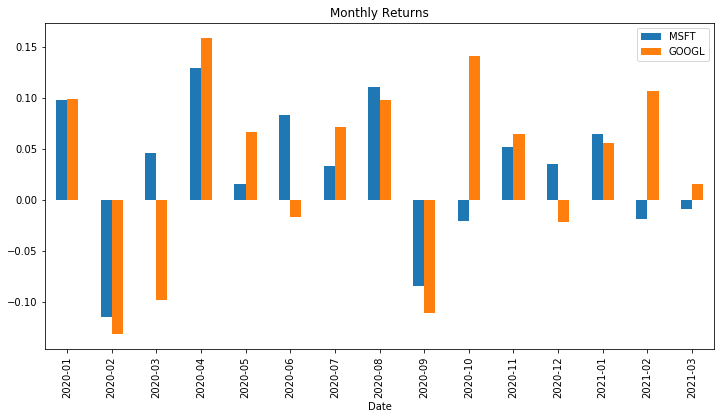

In [11]:
rets["2020":].plot.bar(figsize = (12,6), title = "Monthly Returns")

In [12]:
cumulated_rets = (rets + 1).cumprod() - 1

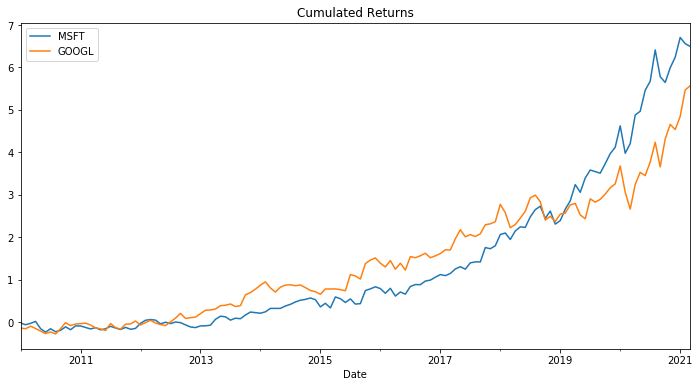

In [13]:
cumulated_rets.plot(figsize=(12,6), title="Cumulated Returns")

In [35]:
weights = np.linspace(0,1,20)
weights = np.array([[w,1-w] for w in np.linspace(0,1,20)])

In [36]:
weights

array([[0.        , 1.        ],
       [0.05263158, 0.94736842],
       [0.10526316, 0.89473684],
       [0.15789474, 0.84210526],
       [0.21052632, 0.78947368],
       [0.26315789, 0.73684211],
       [0.31578947, 0.68421053],
       [0.36842105, 0.63157895],
       [0.42105263, 0.57894737],
       [0.47368421, 0.52631579],
       [0.52631579, 0.47368421],
       [0.57894737, 0.42105263],
       [0.63157895, 0.36842105],
       [0.68421053, 0.31578947],
       [0.73684211, 0.26315789],
       [0.78947368, 0.21052632],
       [0.84210526, 0.15789474],
       [0.89473684, 0.10526316],
       [0.94736842, 0.05263158],
       [1.        , 0.        ]])

In [24]:
er = (1+rets).prod()
cov = (1+rets).cov()

In [77]:
def portfolio_return(weights,returns):
    return weights.T @ returns

def portfolio_volatility(weights, covmat):
    return weights.T @ covmat @ weights

In [98]:
returns = [portfolio_return(w, er) for w in weights]
volatilities = [portfolio_volatility(w,cov) for w in weights]
efficient_frontier = pd.DataFrame({"Return":returns,"Volatility":volatilities})

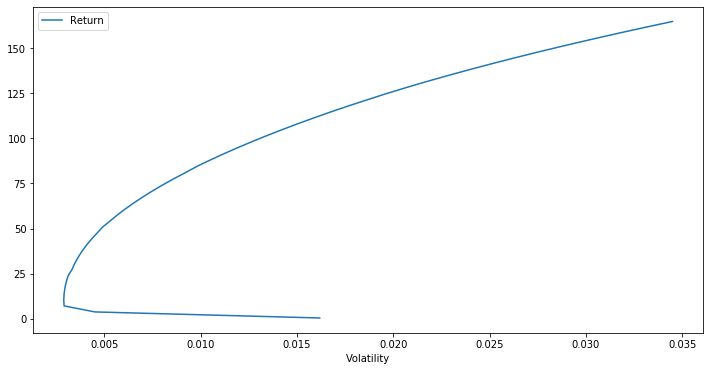

In [99]:
efficient_frontier.plot.line(x="Volatility",y="Return", figsize=(12,6))

# EFficient frontier for more than 2 assets

In [87]:
microsoft_prices = pdr.get_data_yahoo("MSFT")
google_prices = pdr.get_data_yahoo("GOOGL")
amazon_prices = pdr.get_data_yahoo("AMZN")
tesla_prices = pdr.get_data_yahoo("TSLA")
boeing_prices = pdr.get_data_yahoo("BA")
dassault_prices = pdr.get_data_yahoo("AM")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [88]:
microsoft_prices = microsoft_prices[["Open"]]["2010":]
microsoft_prices.columns = ["MSFT"]
google_prices = google_prices[["Open"]]["2010":]
google_prices.columns = ["GOOGL"]
amazon_prices = amazon_prices[["Open"]]["2010":]
amazon_prices.columns = ["AMZN"]
tesla_prices = tesla_prices[["Open"]]["2010":]
tesla_prices.columns = ["TSLA"]
boeing_prices = boeing_prices[["Open"]]["2010":]
boeing_prices.columns = ["BA"]
dassault_prices = dassault_prices[["Open"]]["2010":]
dassault_prices.columns = ["AM"]

In [89]:
prices = pd.concat([microsoft_prices,google_prices,amazon_prices,tesla_prices,boeing_prices,dassault_prices], axis=1)
prices.index = pd.to_datetime(prices.index, format="%Y%m").to_period('M')

rets = prices.pct_change()

rets = (1+rets).groupby("Date").prod() - 1

In [90]:
er = (1+rets).prod()
cov = (1+rets).cov()

In [91]:
def minimize_vol(target_return, er, cov):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n

    weights_to_1 = {'type':'eq', 'fun': lambda weights : np.sum(weights)-1}
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)}
    weights = opt.minimize(portfolio_volatility, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

def optimal_weights(n_points, er, cov):
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

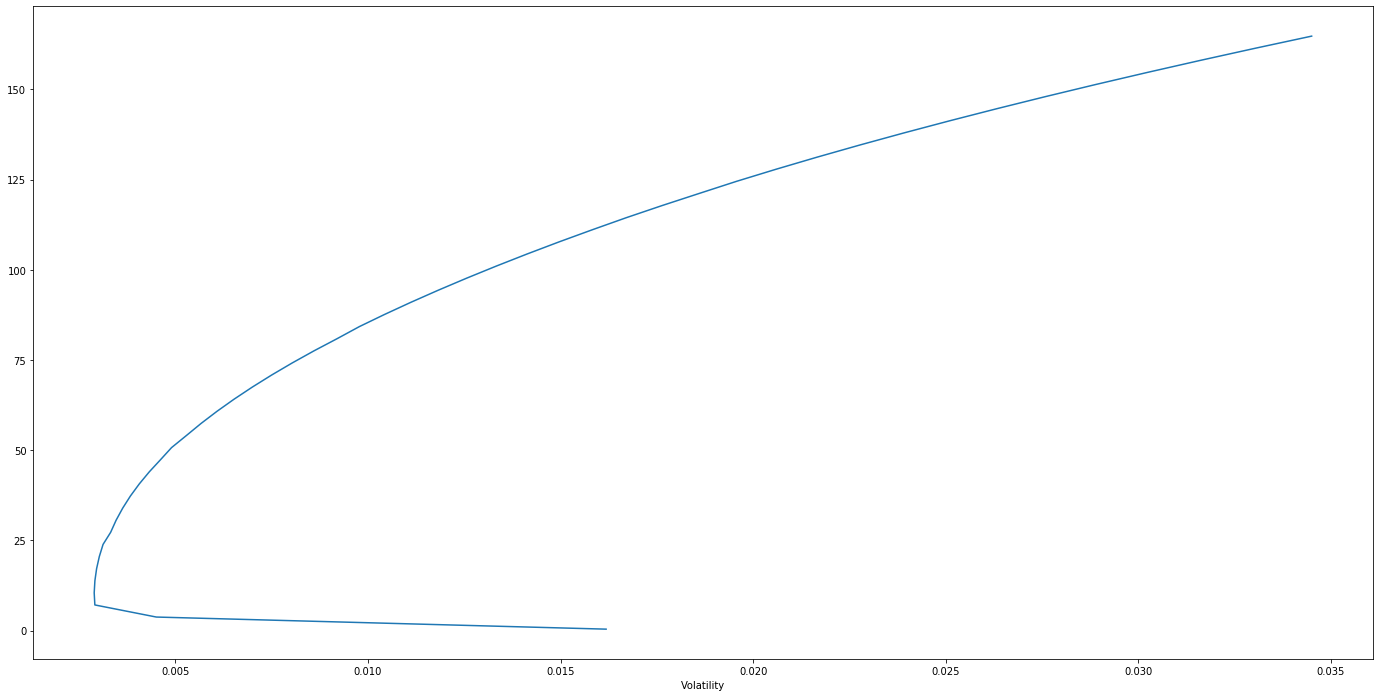

In [97]:
weights = optimal_weights(50, er, cov)
rets = [portfolio_return(w, er) for w in weights]
vols = [portfolio_volatility(w, cov) for w in weights]
ef = pd.DataFrame({
    "Returns": rets, 
    "Volatility": vols
})
ef.plot.line(x="Volatility", y="Returns", style="-", legend=False, figsize=(24,12))